# Over the Hills
Histograms of Formula 1 driver age from
https://ergast.com/mrd/db

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 0

from etl import DATADIR, ErgastF1
from viz import Plot

f1 = ErgastF1(DATADIR / 'ergast/f1.zip')
plot = Plot()

Autosave disabled


## How old was each driver on each podium?
Get driver name and age for each podium finish.

In [2]:
pods = (
    f1.results.loc[lambda df: df['order'].le(3)]
    .join(f1.drivers['driver birthday'.split()], on='id_driver')
    .join(f1.races['date'], on='id_race')
    ['date order driver birthday'.split()]
)
pods['age'] = (pods['date'] - pods.pop('birthday')).dt.days / 365.25

# If co-drivers share a result, then keep the older one.    
pods = (
    pods.sort_values('date order age'.split())
    .drop_duplicates('date order'.split(), keep='last')
    .reset_index(drop=True)    
)
pods

,date,order,driver,age
0,1950-05-13,1,Nino Farina,43.534565
1,1950-05-13,2,Luigi Fagioli,51.923340
2,1950-05-13,3,Reg Parnell,38.863792
3,1950-05-21,1,Juan Fangio,38.907598
4,1950-05-21,2,Alberto Ascari,31.854894
...,...,...,...,...
3049,2019-11-17,2,Pierre Gasly,23.775496
3050,2019-11-17,3,Carlos Sainz,25.210130
3051,2019-12-01,1,Lewis Hamilton,34.896646
3052,2019-12-01,2,Max Verstappen,22.168378


## golden years

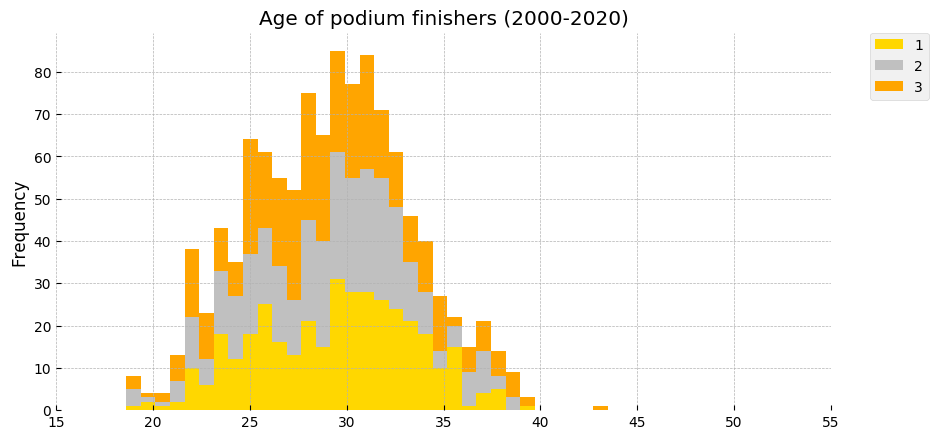

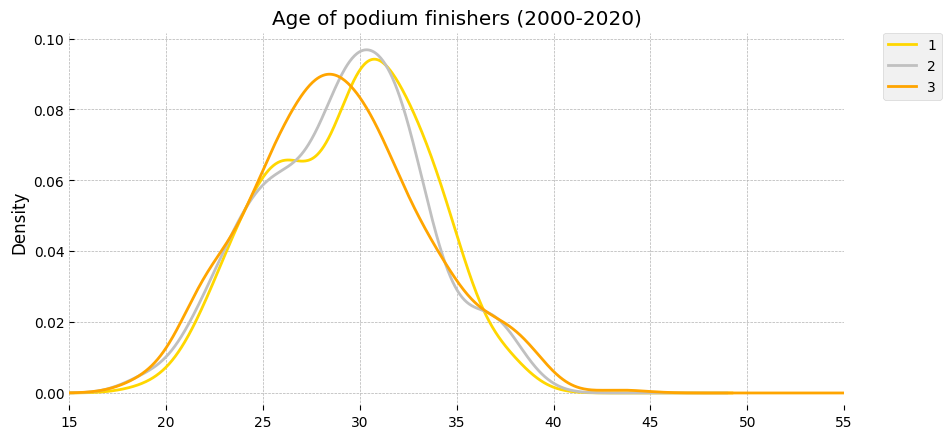

In [3]:
def podhist(start, stop, **kwargs):
    data = pods.pivot(index='date', columns='order', values='age')
    data = data.loc[str(start) : str(stop)]
    
    kwset = kwargs.setdefault
    kwset('color', 'gold silver orange'.split())
    kwset('title', f"Age of podium finishers ({start}-{stop})")
    kwset('xlim', (15, 55))
    
    plot.hist(data, **kwargs)
    plot.density(data, **kwargs)

podhist(2000, 2020)

## all-ages shows

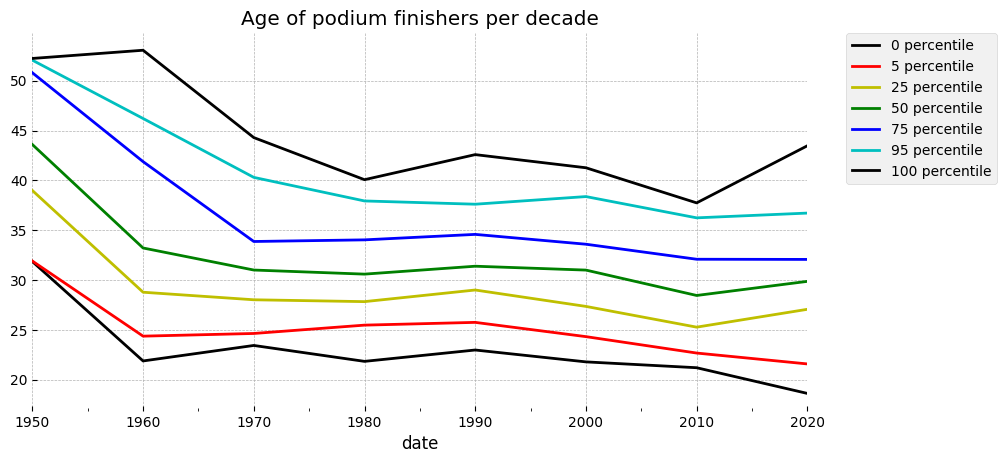

In [4]:
def podquants(**kwargs):
    kwargs.setdefault('title', 'Age of podium finishers per decade')
    data = pods.set_index('date')['age']
    plot.quant(data, '10y', **kwargs)
    
podquants()

## good old boys
Oldest podium finishers.

In [5]:
olds = pods.loc[pods.groupby('driver')['age'].idxmax()]
olds = olds.nlargest(20, 'age')
olds.index = range(1, 1 + len(olds))
olds

,date,order,driver,age
1,1951-07-01,1,Luigi Fagioli,53.056810
2,1950-05-21,3,Louis Chiron,50.795346
3,1953-06-07,3,Felice Bonetto,49.995893
4,1955-09-11,2,Piero Taruffi,48.914442
5,1955-06-05,3,Nino Farina,48.596851
6,1957-09-08,2,Juan Fangio,46.209446
7,1955-07-16,3,Karl Kling,44.829569
8,1950-06-18,3,Louis Rosier,44.616016
9,1953-09-13,3,Luigi Villoresi,44.328542
10,1970-07-18,2,Jack Brabham,44.292950


## the young and the restless
Youngest podium finishers.

In [6]:
utes = pods.loc[pods.groupby('driver')['age'].idxmin()]
utes = utes.nsmallest(20, 'age')
utes.index = range(1, 1 + len(utes))
utes

,date,order,driver,age
1,2016-05-15,1,Max Verstappen,18.622861
2,2017-06-25,3,Lance Stroll,18.655715
3,2008-09-14,1,Sebastian Vettel,21.201916
4,2015-07-26,2,Daniil Kvyat,21.248460
5,2014-03-16,2,Kevin Magnussen,21.442847
6,2019-03-31,3,Charles Leclerc,21.453799
7,2003-03-23,3,Fernando Alonso,21.648186
8,2006-09-10,3,Robert Kubica,21.757700
9,1997-04-13,3,Ralf Schumacher,21.787817
10,1980-01-27,2,Elio de Angelis,21.839836


## gold in them Hills
Oldest podium finishers named Hill.

In [7]:
hills = (
    pods.loc[pods['driver'].str.endswith('Hill')]
    .groupby('driver order'.split())
    ['age'].max().unstack().round(1)
    .rename_axis(None)
)
hills.columns = '1st 2nd 3rd'.split()
hills

,1st,2nd,3rd
Damon Hill,37.9,36.9,35.1
Graham Hill,40.3,40.0,37.4
Phil Hill,34.4,35.1,35.2
